# Introduction to Machine Learning (CSCI-UA.473)

## Lab 3: Logistic Regression

### Goal:  Demonstrate some of the main points about logistic regression and classification metrics.

In [2]:
!pip install autograd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 KB 446.2 kB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/Users/aragaom/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
# Let's import some packages we'll need.
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import make_blobs, load_breast_cancer, load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression
import pandas as pd
import autograd.numpy as np
from autograd import grad

# Using Autograd

Autograd is a package for automatic differentiation.  ``autograd.numpy`` is a wrapper for Numpy which contains the same basic operations.  In most machine learning algorithms we need the gradient of a certain loss function to fit our model to the given data.  Autograd computes this gradient automatically for us so that we may use methods such as gradient descent.  A popular function used in logistic regression as well as neural nets is the sigmoid function

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

The derivative is given by

$$
\sigma'(x) = \frac{e^{-x}}{(1 + e^{-x})^2} = \sigma(x) (1 - \sigma(x))
$$

We could either compute this derivative by hand and then hard code it explicitly, or we could just call autograd.

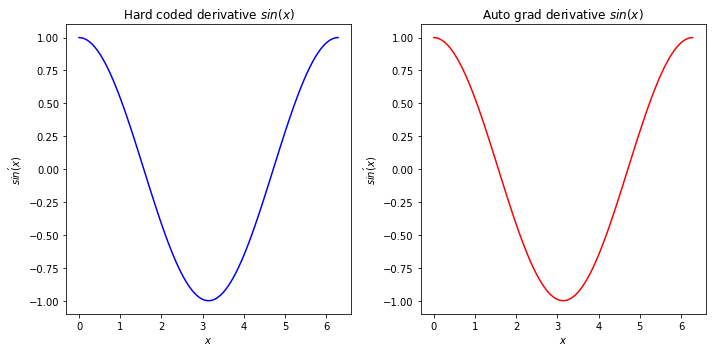

In [4]:
#Use sine instead
# Define the sigmoid function.
def sin(x):
    return np.sin(x)

# Hard code the gradient of the sigmoid function.
def grad_sin(x):
    return np.cos(x)


# Evaluate the gradient using autograd.
autograd_sin = grad(sin)

# Plot the two gradients side by side.
x = np.linspace(0, 2*np.pi, 100)


# We'll have 2 plots side by side.
fig = plt.figure(3, figsize = (10, 5))

# First plot the autograd derivative.
ax1 = plt.subplot(121) # create a figure with 1 row and 2 columns and get the axis 
y1 = np.asarray([grad_sin(x[i]) for i in range(len(x))])
ax1.plot(x, y1, 'b')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$sin\'(x)$')
ax1.set_title(r'Hard coded derivative $sin(x)$')

# Second plot the hard-coded derivative.
ax2 = plt.subplot(122)
y2 = np.asarray([autograd_sin(x[i]) for i in range(len(x))])
ax2.plot(x, y2, 'r')
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$sin\'(x)$')
ax2.set_title(r'Auto grad derivative $sin(x)$')

plt.tight_layout();

## Part 1: Logistic Regression using Synthetic Data and Autograd

We will play around with the logistic regression model implemented from scratch and trained using autograd on synthetic data. 

### Generate the data and plot it

In [7]:
! pip install ipympl
! jupyter nbextension install --py --symlink --sys-prefix --overwrite ipympl
! jupyter nbextension enable --py --sys-prefix ipympl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.3/510.3 KB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 KB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.4 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.3/384.3 KB 586.5 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.5.1
    Uninstalling widgetsnbextension-3.5.1:
      Successfully uninstalled widgetsnbextension-3.5.1
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.5.1
    Uninstalling ipywidgets-7.5.1:
      Successfully uninstalled ipywidgets-7.5.1
You should consider upgrading via the '/Users/aragaom/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Installing /Users/aragaom/opt/anaconda3/lib/python3.8/site-packages/ipympl/nbextension -> jupyter-matplotlib
Removing: /Users/aragaom/opt/anaconda3/shar

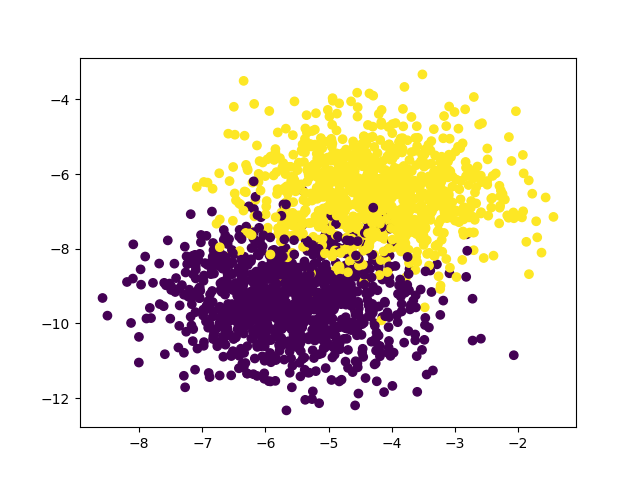

In [8]:
# For the plots in the remainder of this notebook we will use a widget to get interactive and better looking plots! 
# follow these instructions to set up matplotlib widget for Jupyter Lab
# https://github.com/matplotlib/jupyter-matplotlib#installation
# Specifically you will need to install the widget using : conda install -c conda-forge ipympl
# To enable the widget run the following two commands :
# jupyter nbextension install --py --symlink --sys-prefix --overwrite ipympl
#jupyter nbextension enable --py --sys-prefix ipympl

%matplotlib widget

import numpy
from tqdm import tqdm

# random_seed = numpy.random.randint(0,100)
random_seed = 65

x, y = make_blobs(n_samples=2000, centers=2, n_features=2, random_state=random_seed)

fig = plt.figure()
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

Now we have a set of data points $\{(x_{1}, y_{1}), (x_{2}, y_{2}), ... , (x_{n}, y_{n})\}$, where $x_{i} \in R^{d}$ are the feature vectors and $y_{i} \in \{0, 1\}$ are the class labels.

### Split the data into training set and validation set
We consider the first 1500 points as our training set and the remaining 500 as our validation set. 
<b>Is this correct?</b> 

In [9]:
x_train, y_train = x[:1500], y[:1500]
x_val, y_val = x[1500:], y[1500:]

# sanity check
assert len(x_train) == len(y_train) == 1500
assert len(x_val) == len(y_val) == 500

# should we check anything else? 

### Build the model
Logistic regression model outputs the posterior probability of the class label to be equal to 1. 
$$p_{+} = p(y = 1|x) = \frac{1}{1 + e^{-w \cdot x + b}},$$ 
where $w \in R^{d}$ and $b \in R$.

Sigmoid function is used to convert the output of the linear operation into probabilities. 

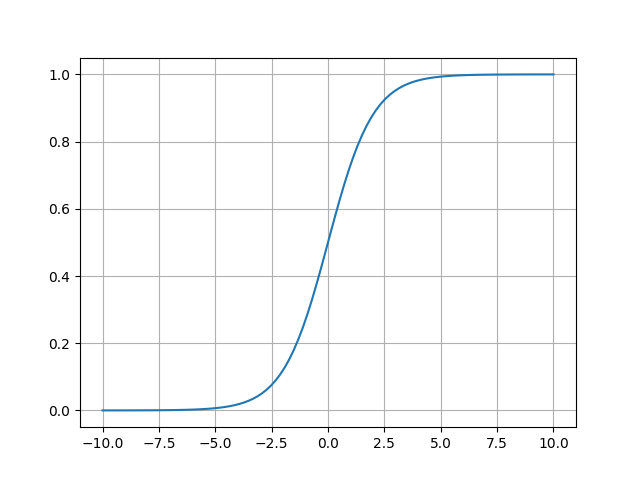

In [10]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

def plot_function(f):
    x = numpy.linspace(-10,10,100)
    y = f(x)
    
    return plt.plot(x,y)

plt.figure()
plot_function(sigmoid)
plt.grid(True)
plt.show()

Now lets build the logistic regression model. 

In [11]:
def logistic_unit(x, w, b):
    """This function computes logistic unit as defined $p_{+}$ above
    :param x: input x with n_dim features
    :param w: weght vector
    :param b: bias vector
    """
    
    # operator @ means matrix multiplication in python <3.5
    # https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.matmul.html#numpy.matmul
    
    pre_sigmoid = x @ w + b
    logit = sigmoid(pre_sigmoid)
    
    return logit

### Loss Function
The loss function of the logistic regression is given by: 

$$\mathcal{L}(x,y) = - ( y \cdot \log(p_{+}) + (1 - y) \cdot \log(1 - p_{+}) )$$

Note that $p_{+}$ depends on $x$ and $w$. 

In [12]:
NEAR_ZERO = 1e-12

def loss_function(x, y, w, b):
    """This function computes the loss (distance)
    :param logits: output from logistic unit
    :param labels: target label
    """
    logits = logistic_unit(x,w,b)
    labels = y
    
    loss = -(labels * numpy.log(logits + NEAR_ZERO) + (1 - labels) * numpy.log(1 - logits + NEAR_ZERO))
    
    return loss


Now lets do a sanity check and compute the loss between the target and prediction given a randomly initialized model.

In [13]:
# sanity check
n_dim=2
w0 = 0.01 * numpy.random.randn(n_dim)
b0 = 0.0

inp = x_train[0]
label = y_train[0]

out = logistic_unit(inp, w0, b0)
assert (out < 1) and (out > 0)  # why?

loss = loss_function(inp, label, w0, b0)
print(loss)

0.8152078622618171


The difference between linear regressiona nd logistic regression. linear regression has a close form? logistic regression we need to start the weights and biases with some sort of initialization. 


### Use Autograd for computing the derivatives and train the model
With Autograd we do not need to compute the gradients by hand and code it. This is very handy when we have huge DAG (Directed Acyclic Graph) computations.
There is an active line of research in automatic differentiation, curious students are adviced to read this:
http://jmlr.org/papers/volume18/17-468/17-468.pdf

In [14]:
# Install autograd:
#!conda install -c conda-forge autograd

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import elementwise_grad

import scipy.optimize

In [15]:
loss_grad_w = elementwise_grad(loss_function, 2) # partial derivative wrt the weights w (3rd input)
loss_grad_b = elementwise_grad(loss_function, 3) # partial derivative wrt the bias b (4th input)

In [16]:
n_iter = 10000
eta = .0001   # Learning rate
w = numpy.copy(w0)
b = numpy.copy(b0)

loss_log = []

for ni in tqdm(range(n_iter)):
    dw = loss_grad_w(x_train, y_train, w, b)
    db = loss_grad_b(x_train, y_train, w, b)
    w -= eta * dw
    b -= eta * db
    
    loss = numpy.mean(loss_function(x_train, y_train, w, b))
    loss_log.append(loss)

100%|██████████| 10000/10000 [00:09<00:00, 1065.88it/s]


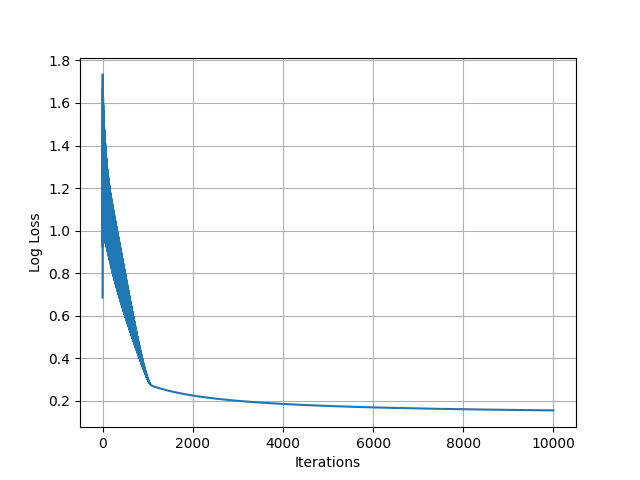

In [17]:
# lets plot the running element-wise loss value
plt.figure()
plt.plot(loss_log)
plt.grid(True)
plt.ylabel("Log Loss")
plt.xlabel("Iterations")
plt.show()

### Plot the data: the actual data and the model (hyperplane)
We start with first defining some visualization routines and then we do the actual plotting. 

Some visualization routines: 

In [18]:
# visualize data 
def vis_data(x, y = None, c='b'):
    if y is None: 
        y = [None] * len(x)
    for x_, y_ in zip(x, y):
        if y_ is None:
            plt.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else 'r'+'+')
    plt.grid('on')
    
def vis_hyperplane(w, b, typ='k--'):

    lim0 = plt.gca().get_xlim()
    lim1 = plt.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + b)/w[1]
    intercept1 = -(w[0] * m1 + b)/w[1]
    
    plt1, = plt.plot([m0, m1], [intercept0, intercept1], typ)

    plt.gca().set_xlim(lim0)
    plt.gca().set_ylim(lim1)
        
    return plt1

def vis_decision_boundary_contour(w, b, typ='k--'):
    
    lim0 = plt.gca().get_xlim()
    lim1 = plt.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1)
    
    pred = logistic_unit(x_tra_, w, b)
    plt1 = plt.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)
    
    plt.colorbar(plt1)
    
    plt.gca().set_xlim(lim0)
    plt.gca().set_ylim(lim1)
        
    return plt1

Now plot the data. 

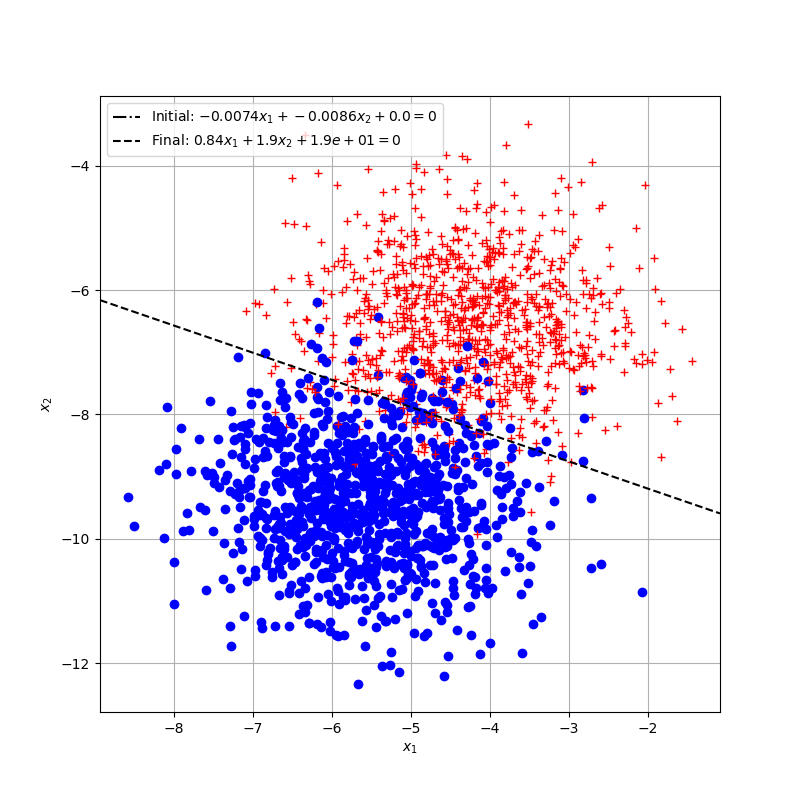

In [35]:
plt.figure(figsize=(8,8))

vis_data(x, y, c='b')

plt0 = vis_hyperplane(w0, b0, 'k-.')
plt1 = vis_hyperplane(w, b, 'k--')
plt.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)+[b0]),
        'Final: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w)+[b])],
           loc='best')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## Part 2: Logistic Regression for Breast Cancer Classification using Sklearn

We will now implement and train another logistic regression model using Sci-kit learn. The goal will be to implement the model, which given a new data point infers the probability of breast cancer. 

Helper method below copied from: [Helper Method](https://stackoverflow.com/questions/38105539/how-to-convert-a-scikit-learn-dataset-to-a-pandas-dataset)

In [21]:
# General helper method to convert sci-kit datasets to Pandas DataFrame.
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

Let's eyeball the data a little bit in a quick and hacky manner. Always a good practice to see what the data looks like. **The training data of course!**

In [22]:
cancer_dataset = load_breast_cancer() # Load the data and convert to a pandas dataframe
df = sklearn_to_df(cancer_dataset)

print(df.head()) # Print out the first five data points.


   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

Let's gather a few summary statistics about our data. Again, always a good practice. 

N = 569 data points


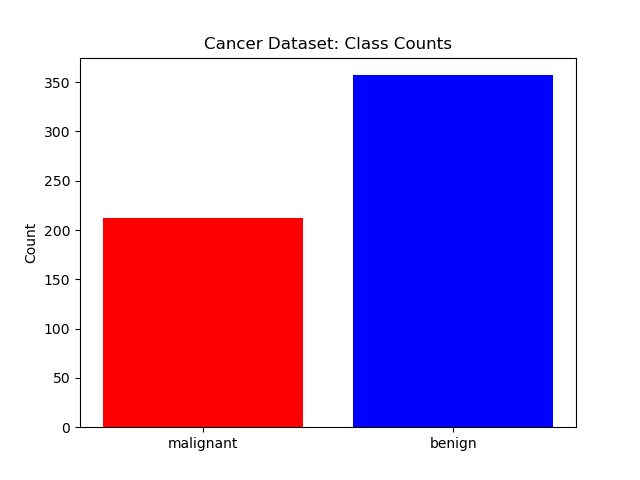

In [23]:
N = len(df) # The number of data points.
print('N = {:d} data points'.format(N))

# Give a barplot of each class.
plt.figure()
plt.bar([0,1], df['target'].value_counts(ascending = True), color = ['r', 'b'], tick_label = cancer_dataset.target_names)
plt.ylabel('Count')
plt.title('Cancer Dataset: Class Counts');

This dataset is unbalanced because there are more examples of benign cancer than malignant.  This is typical of many real-life datasets where we are sometimes limited in how many training examples we have.  Let's split our data into a training and validation set.  We'll use a 80/20 split.

In [24]:
# Split the data.  DO NOT TOUCH THE TEST DATA FROM HERE ON!!
train_data, val_data = model_selection.train_test_split(df, test_size = 0.2) # 0.2 is 20% validation data.

# Split the features from the class labels.
X_train = train_data.drop('target', axis = 1) # We drop the target from the features.  
X_val  = val_data.drop('target', axis = 1)  # Note that this does not operate inplace.
 
y_train = train_data['target']
y_val  = val_data['target']

Now that our data is loaded and split we can train a logistic regression model.  For the optimization we use the "liblinear" solver.  There are many other solvers that are also available, such as Newton CG for example.  For more information there is a nice stackexchange post here: [Solvers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [25]:
# Now fit a logistic regression model.
model = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')
model.fit(X_train, y_train);

The model is trained so we can validate it on our validation set.  The Sci-kit metrics module contains many useful functions for this purpose.  We try out a few of them below. 

Let us first briefly explain some of these metrics we will use.  

#### Accuracy 
Accuracy is obviously the percentage of all correctly classified examples in our test set.  

#### Confusion Matrix
The confusion matrix is the following matrix:
$$
C = \begin{bmatrix}
\text{Predict 0, Actual 0} & \text{Predict 0, Actual 1}\\
\text{Predict 1, Actual 0} & \text{Predict 1, Actual 1}
\end{bmatrix}
$$
Notice that the diagonal entries are the examples that are correctly classified.  

#### Precision Score
The precision score is the percentage 
$$
\text{Precision } = \frac{C_{00}}{C_{00} + C_{01}}.
$$
So it is the percentage of predicted malignant tumors that we classify correctly.  

#### Recall Score 
The recall score is the percentage
$$
\text{Recall } = \frac{C_{00}}{C_{00} + C_{10}}
$$
So it is the percentage of malignant tumors that we classify correctly. Note that Precision and Recall are two different quantities.

**Using multiple evaluation metrics helps give a better picture of how well our classifier is doing.**

In [26]:
pred = model.predict(X_val)

# See the percentage of examples that are correctly classified.
accuracy = metrics.accuracy_score(y_val, pred) 
print("Accuracy = {:0.1f}%".format(accuracy * 100))

# The matrix of predictions and true values for each class.
conf_matrix = metrics.confusion_matrix(y_val, pred)
print("Confusion matrix = ")
print(conf_matrix)

# Precision score.
precision = metrics.precision_score(y_val, pred)
print("Precision = {:0.1f}%".format(100 * precision))

# Recall score.
recall = metrics.recall_score(y_val, pred)
print("Recall    = {:0.1f}%".format(100 * recall))

Accuracy = 96.5%
Confusion matrix = 
[[37  1]
 [ 3 73]]
Precision = 98.6%
Recall    = 96.1%


## Part 3: Multiclass Classification

Multiclass classification is just when we have more than 2 classes.  Instead of modeling the posterior class probabilities as Bernoulli random variables, we can model them as multinomial random variables for example.  The example we'll consider here is the classic Iris dataset by Fisher (a prominent early statistician).  Let's load the data below.

In [27]:
# Load the data and convert it into a Pandas dataframe.
iris_data = load_iris()
df = sklearn_to_df(iris_data)

# Print the first 5 examples to see how the data looks.
print("N = ", len(df))
print(df.head())

N =  150
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


### Split the data into train and test

We'll use a 80/20 split for our training/test sets. We will not touch the test set. For validation purposes we will use cross validation. This is particularly useful in this situation since we only have 150 examples in our dataset. We will use $k$-fold cross-validation with $k=10$.  This works by splitting the training data into 10 disjoint sets.  We then leave out one of these sets and train our model on the remaining 9 sets and treat the left out set as a validation set.  We repeat this a total of 10 times and average the validation scores.  If $k = N$ is the number of samples, then this is also called leave one out cross-validation (LOOCV).  Note that using $k$-fold cross-validation is more expensive than if we had a separate validation set to begin with because we have to train our model many times.

Cross-validation will become more useful when we have a hyperparameter to control during training and want to see which value of the hyperparameter will give the best results.

In [28]:
# Split the data.  DO NOT TOUCH THE TEST DATA FROM HERE ON!!
train_data, test_data = model_selection.train_test_split(df, test_size = 0.2) # 0.2 is 20% test data.

# Split the features from the class labels.
X_train = train_data.drop('target', axis = 1) # We drop the target from the features.  
X_test  = test_data.drop('target', axis = 1)  # Note that this does not operate inplace.
 
y_train = train_data['target']
y_test  = test_data['target']

Below we compare 2 logistic regression models using cross-validation.  The first model is trained on all of the features whereas the second model is only trained on "sepal length" and "sepal width".

In [29]:
# Get the 2 different models.
model1 = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')
model2 = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')

X_train2 = X_train[['sepal length (cm)', 'sepal width (cm)']]

# k-fold cross-validation.
k = 10
splitter = model_selection.KFold(k)

# Compute cross-validation scores.
cv_scores1 = model_selection.cross_val_score(model1, X_train, y_train, cv = splitter)
cv_scores2 = model_selection.cross_val_score(model2, X_train2, y_train, cv = splitter)

# Print the means of the scores.
print("Model 1 CV score = ", np.mean(cv_scores1))
print("Model 2 CV score = ", np.mean(cv_scores2))

Model 1 CV score =  0.9583333333333333
Model 2 CV score =  0.7916666666666666


### Learning curves

We can also look to see how our two models perform when given additional training examples.  A learning curve shows the tradeoff between the number of samples we use to train and the model's predictive accuracy.  We plot the learning curves for our two models below.

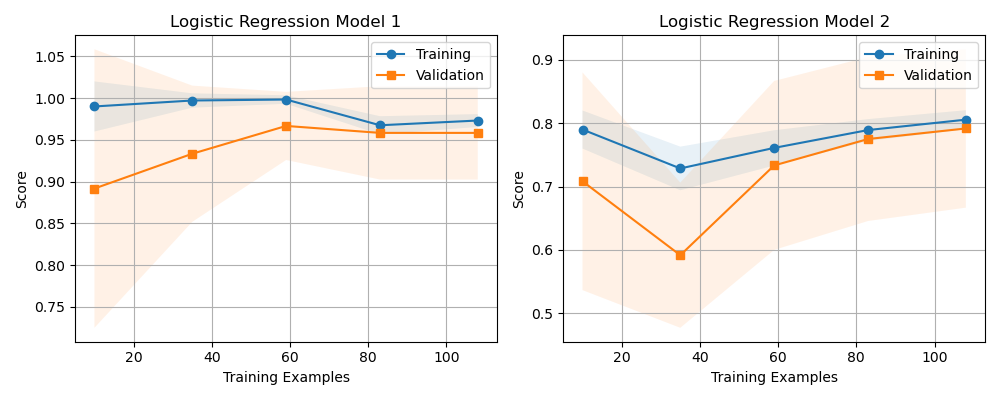

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))

train_sizes1, train_scores1, test_scores1 = model_selection.learning_curve(model1, X_train, y_train, cv = splitter)
train_sizes2, train_scores2, test_scores2 = model_selection.learning_curve(model2, X_train2, y_train, cv = splitter)

train_scores_mean1 = np.mean(train_scores1, axis = 1)
test_scores_mean1  = np.mean(test_scores1, axis = 1)
train_scores_std1  = np.std(train_scores1, axis = 1)
test_scores_std1   = np.std(test_scores1, axis = 1)

train_scores_mean2 = np.mean(train_scores2, axis = 1)
test_scores_mean2  = np.mean(test_scores2, axis = 1)
train_scores_std2  = np.std(train_scores2, axis = 1)
test_scores_std2   = np.std(test_scores2, axis = 1)

ax1.set_title('Logistic Regression Model 1')
ax1.plot(train_sizes1, train_scores_mean1, 'o-', label = 'Training')
ax1.plot(train_sizes1, test_scores_mean1, 's-', label = 'Validation')
ax1.fill_between(train_sizes1, train_scores_mean1 - train_scores_std1, train_scores_mean1 + train_scores_std1, alpha = 0.1)
ax1.fill_between(train_sizes1, test_scores_mean1 - test_scores_std1, test_scores_mean1 + test_scores_std1, alpha = 0.1)
ax1.set_xlabel('Training Examples')
ax1.set_ylabel('Score')
ax1.grid()
ax1.legend()

ax2.set_title('Logistic Regression Model 2')
ax2.plot(train_sizes2, train_scores_mean2, 'o-', label = 'Training')
ax2.plot(train_sizes2, test_scores_mean2, 's-', label = 'Validation')
ax2.fill_between(train_sizes2, train_scores_mean2 - train_scores_std2, train_scores_mean2 + train_scores_std2, alpha = 0.1)
ax2.fill_between(train_sizes2, test_scores_mean2 - test_scores_std2, test_scores_mean2 + test_scores_std2, alpha = 0.1)
ax2.set_xlabel('Training Examples')
ax2.set_ylabel('Score')
ax2.grid()
ax2.legend()

plt.tight_layout();

### Evaluate the models.

Finally, we actually evaluate our two models on our test set.  The first model has a higher cross-validation score so we expect it to do better on the test set.

In [31]:
model1.fit(X_train, y_train)
model2.fit(X_train2, y_train)

pred1 = model1.predict(X_test)

X_test2 = X_test[['sepal length (cm)', 'sepal width (cm)']]
pred2 = model2.predict(X_test2)

# Get the percent of correctly classified results.
acc1 = metrics.accuracy_score(pred1, y_test)
acc2 = metrics.accuracy_score(pred2, y_test)

print("Logistic regression model accuracy (all features) = {:0.1f}%".format(100 * acc1))
print("Logistic regression model accuracy (2 features)   = {:0.1f}%".format(100 * acc2))

Logistic regression model accuracy (all features) = 96.7%
Logistic regression model accuracy (2 features)   = 83.3%


As we'd expect, training with more features gives us a more flexible model.  Excluding the remaining features is equivalent to setting their weights to 0.  Thus, we are solving a constrained minimization problem when we train, which will worse than solving the unconstrained problem where we are using all of the features.